# Spectral analysis of ECG signal using Python packages. 

Or use frequencies to get embeddings (use images of ECG)

- Fourier & Wavelet Spectrograms

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from scipy.signal import resample
import torch
from transformers import AutoTokenizer, AutoModel
import ast
import scipy.io as sio
from scipy.signal import spectrogram

c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
sys.path.append('C:/Users/navme/Desktop/ECG_Project/PyFiles')

In [3]:
from helper_functions import *
from dataset import PhysioNetDataset

In [4]:
PhysioNet_PATH = f'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'
PhysioNet_PATH

'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'

In [5]:
train_set = PhysioNetDataset(PhysioNet_PATH, train=True)
val_set = PhysioNetDataset(PhysioNet_PATH, train=False)

In [6]:
train_set[0][1]

{'val': array([[408.24601882, 408.24601882, 408.24601882, ..., -83.34581329,
         -74.965045  , -63.10339951],
        [-92.07603073, -92.07603073, -92.07603073, ...,  57.20010276,
          54.51591647,  58.88514819],
        [225.08001192, 225.08001192, 225.08001192, ...,  93.39571052,
          97.44912853, 117.96825132]])}

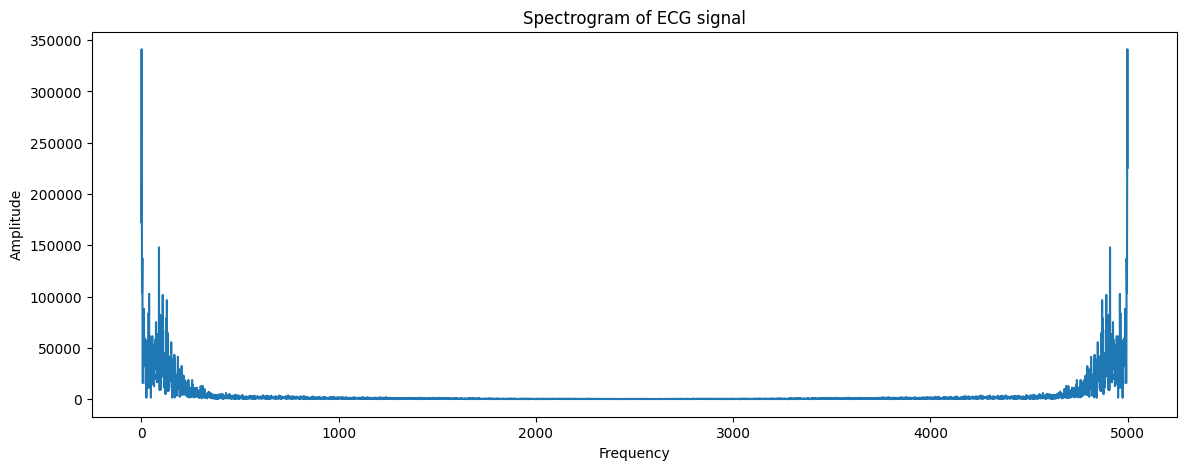

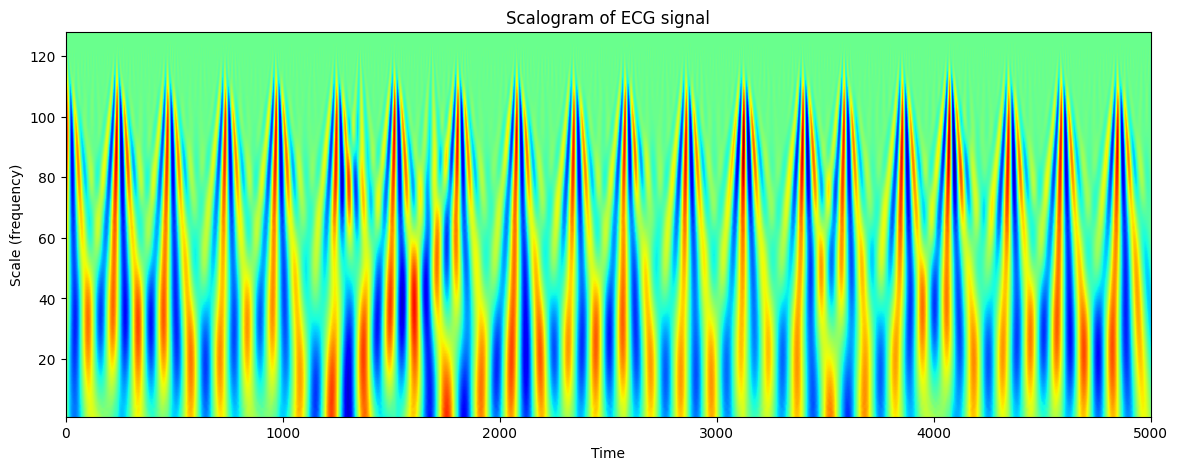

In [7]:
import matplotlib.pyplot as plt
from scipy.fft import fft
import pywt

# 1. Extract ECG signal
# Assuming the 'val' is your ECG signal and selecting the first lead
index = 0  # change this to choose different signals
ecg_data = train_set[index][1]['val']
ecg_signal = ecg_data[0]  # selecting the first lead

# 2. Apply Fourier Transform
ecg_fft = fft(ecg_signal)

# 3. Visualize Fourier Transform (Spectrogram)
plt.figure(figsize=(14, 5))
plt.plot(np.abs(ecg_fft))
plt.title('Spectrogram of ECG signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

# 4. Apply Wavelet Transform
waveletname = 'morl'
coeffs, freqs = pywt.cwt(ecg_signal, np.arange(1, 128), waveletname)

# 5. Visualize Wavelet Transform (Scalogram)
plt.figure(figsize=(14, 5))
plt.imshow(coeffs, aspect='auto', cmap='jet', 
           extent=[0, len(ecg_signal), 1, 128])
plt.title('Scalogram of ECG signal')
plt.xlabel('Time')
plt.ylabel('Scale (frequency)')
plt.show()

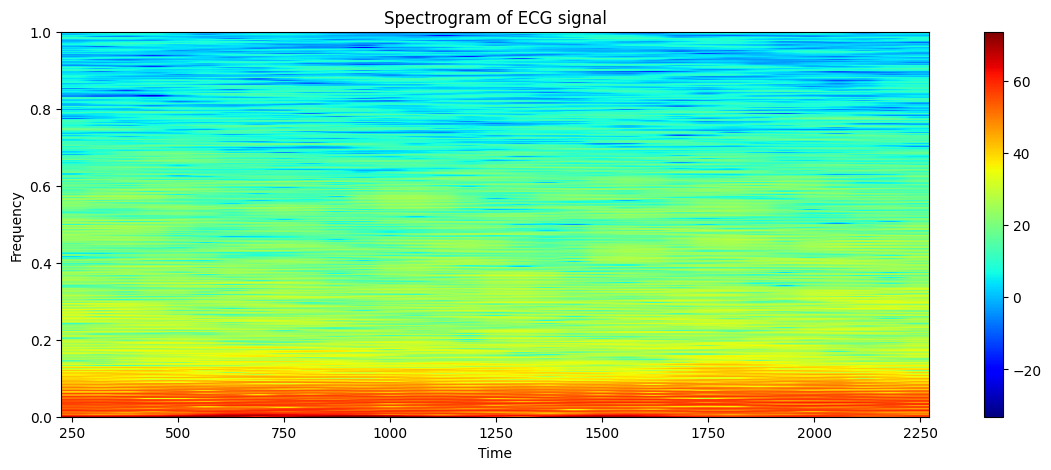

In [8]:
# 6. Apply Fourier Transform and plot spectrogram
plt.figure(figsize=(14, 5))
Pxx, freqs, bins, im = plt.specgram(ecg_signal, NFFT=1024, Fs=2, noverlap=900, cmap='jet')
plt.title('Spectrogram of ECG signal')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()

# Save the figure as an image
plt.savefig('spectrogram_example.png', dpi=300, bbox_inches='tight')

plt.show()

# ECGSpectrogramGenerator()

In [9]:
import scipy.io as sio

class ECGSpectrogramGenerator:
    def __init__(self, save_dir):
        self.save_dir = save_dir

    def generate_spectrogram(self, mat_file, recording_number):
        # Load the ECG signal from the .mat file
        ecg_signal = sio.loadmat(mat_file)['val']

        # Generate a spectrogram for each lead
        for lead_id, lead_signal in enumerate(ecg_signal):
            plt.figure(figsize=(14, 5))
            Pxx, freqs, bins, im = plt.specgram(lead_signal, NFFT=1024, Fs=2, noverlap=900, cmap='jet')
            plt.title(f'Spectrogram of ECG signal {recording_number}, lead {lead_id}')
            plt.xlabel('Time')
            plt.ylabel('Frequency')
            plt.colorbar()

            # Save the figure as an image
            plt.savefig(os.path.join(self.save_dir, f'spectrogram_{recording_number}_lead_{lead_id}.png'), dpi=300, bbox_inches='tight')
            plt.close()

In [10]:
ecg_spectrogram_generator = ECGSpectrogramGenerator('C:/Users/navme/Desktop/ECG_Project/Spectrograms')

In [11]:
for i in range(1):  # only process the first record. There should be 12 spectrogram images, one for each lead
    mat_file = train_set._mat_files[i]
    recording_number = i  # or replace with actual recording number if available
    ecg_spectrogram_generator.generate_spectrogram(mat_file, recording_number)

In [12]:
#import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [13]:
class OneDimCNN(nn.Module):
    def __init__(self, num_classes):
        super(OneDimCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 5
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 6
        self.conv6 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 7
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm1d(1024)
        self.relu7 = nn.ReLU()
        self.pool7 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 8
        self.conv8 = nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm1d(2048)
        self.relu8 = nn.ReLU()
        self.pool8 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 9
        self.conv9 = nn.Conv1d(in_channels=2048, out_channels=4096, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm1d(4096)
        self.relu9 = nn.ReLU()
        self.pool9 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Fully Connected Layer 1
        self.fc1 = nn.Linear(4096, 128)  # Adjusted to match output channels of last conv layer
        self.relu10 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        # Fully Connected Layer 2
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Layer 6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        # Layer 7
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.pool7(x)

        # Layer 8
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool8(x)

        # Layer 9
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu9(x)
        x = x.view(x.size(0), -1)

        # Dynamically adjust the input size of the first fully connected layer
        if self.fc1.in_features != x.size(1):
            self.fc1 = nn.Linear(x.size(1), 128)

        # Fully Connected Layer 1
        x = self.fc1(x)
        x = self.relu10(x)  # Renamed from relu5 to relu10
        x = self.dropout1(x)

        # Fully Connected Layer 2
        x = self.fc2(x)

        return x

In [14]:
class ECGEncoder(OneDimCNN):
    def __init__(self, num_classes, embedding_size=768):
        super(ECGEncoder, self).__init__(num_classes)
        self.fc = nn.Linear(133, embedding_size)  # Add a fully connected layer

    def encode(self, signal):
        encoded_signal = self.forward(signal)
        encoded_signal = self.fc(encoded_signal)  # Transform the embedding to the common size
        return encoded_signal

In [15]:
import torch
from PIL import Image
from torchvision.transforms import ToTensor

In [16]:
# Instantiate the ECGEncoder
model = ECGEncoder(num_classes=10, embedding_size=768)

In [ ]:
for lead in range(12):  # there should be 12 spectrogram images, one for each lead
    img = Image.open(f'C:/Users/navme/Desktop/ECG_Project/Spectrograms/spectrogram_0_lead_{lead}.png')
    img = ToTensor()(img)  # convert the image to a tensor
    img = img.unsqueeze(0)  # add batch dimension

    # Get the embeddings of the spectrogram
    embeddings = model.encode(img)

    print(f'Embeddings for lead {lead}:', embeddings.shape)  # should be (1, 768)

To use a 2D spectrogram image in the model, the ECGEncoder and OneDimCNN need to be updated accordingly. At present, ECGEncoder was designed for 1D ECG signals, not 2D spectrograms. 

2D spectrograms can be converted to 1D but we will lose some information whether it's time or frequency. Perhaps take the mean along one axis which gives us the average at each frequency? 
